<a href="https://colab.research.google.com/github/BirukovAlex/neto_Python/blob/main/%D0%94%D0%97_%D0%BF%D1%80%D0%BE%D0%B1%D0%BB%D0%B5%D0%BC%D0%B0_%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Домашнее задание «Проблема качества данных»**

- Проведите очистку данных на примере датасета с информацией о пассажирах корабля Титаник.
- Данные можно скачать по ссылке или найти в материалах к уроку.
- На полученных данных обучите модель классификации, с целевым признаком Survived (1 – пассажир выжил, 0 – погиб).
- Обучите модель на необработанных данных и посчитайте метрику качества.
- Проведите очистку данных.
- Обучите модель на данных после обработки, посчитайте метрику качества.
- Сравнить полученные результаты. Значение метрики должно улучшиться.

Описание датасета (train)

- PassengerId — уникальный идентификатор пассажира;
-Survived — факт выживания (1 = выжил, 0 = погиб);
-Pclass — класс билета/социально-экономический статус (1 = высший, 2 = средний, 3 = низший);
-Name — имя и фамилия пассажира;
-Sex — пол пассажира;
-Age — возраст пассажира (часть значений отсутствует);
-SibSp — число родных братьев/сестёр или супругов на борту;
-Parch — число родителей/детей на борту;
-Ticket — номер билета;
-Fare — стоимость проезда;
-Cabin — номер каюты (значительная часть значений отсутствует);
-Embarked — порт посадки (С = Шербург, Q = Куинстаун, S = Саутгемптон).

In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, recall_score, precision_score, accuracy_score, roc_curve, roc_auc_score, auc, precision_recall_curve


In [59]:
df = pd.read_csv('train.csv')

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Рассуждаем о том, что видим:
- пропуски в age, cabin и embarked.
- категориальные признаки name, sex, ticket, cabin, embarked.  
    
    *Наша задача состоит в том, чтобы  модель предсказала выживаемость пассажира и нужно определиться с коррелирующими признаками*

мы видим, что:
- целевая переменная survived - целочисленная, без пропусков (+)
- признак "пол" важен для анализа, преобразовываем в 0,1 (labelEncoder).
- категориальные признаки name, ticket, Cabin, Embarked неважны (выживаемость не зависит).
- **важный признак - возраст, имеет существенно много пропусков (177 | 19%)**  


**В первую очередь обработаем пропуски Age** следующим образом: добавим новый признак "Взрослые" (если да - 1, если нет - 0). В категорию детей будем добавлять по следующему признаку: возраст пассажира <=12, если Age == Nan и Parch != 0 (на борту есть родители) и в Name содержится обращение к пассажиру Master (по правилам 1912 года так обращались к мальчикам 12 лет).
Если в Age == Nan и Parch != 0 и в Name содержится обращение к пассажиру Miss - то оставляем Nan, потому что обращение Miss было ко всем девочкам и женщинам вне зависимости от возраста.

In [61]:
# Создание колонки Adult
df['Adult'] = 1  # По умолчанию все взрослые (1)

# Определение детей (0) по возрасту <=12
df.loc[df['Age'] <= 12, 'Adult'] = 0
# Обработка случаев с пропущенным возрастом
mask = (
    df['Age'].isna() &
    (df['Parch'] != 0) &
    df['Name'].str.contains('Master')
)
df.loc[mask, 'Adult'] = 0
# Обработка случаев с Miss - оставляем NaN
miss_mask = (
    df['Age'].isna() &
    (df['Parch'] != 0) &
    df['Name'].str.contains('Miss')
)
df.loc[miss_mask, 'Adult'] = np.nan
# Преобразование в int64 (где возможно)
df['Adult'] = df['Adult'].astype('Int64')  # Используем pandas' Int64 для поддержки NaN

Корреляция Survived-Age: -0.065
Корреляция Survived-Adult: -0.118


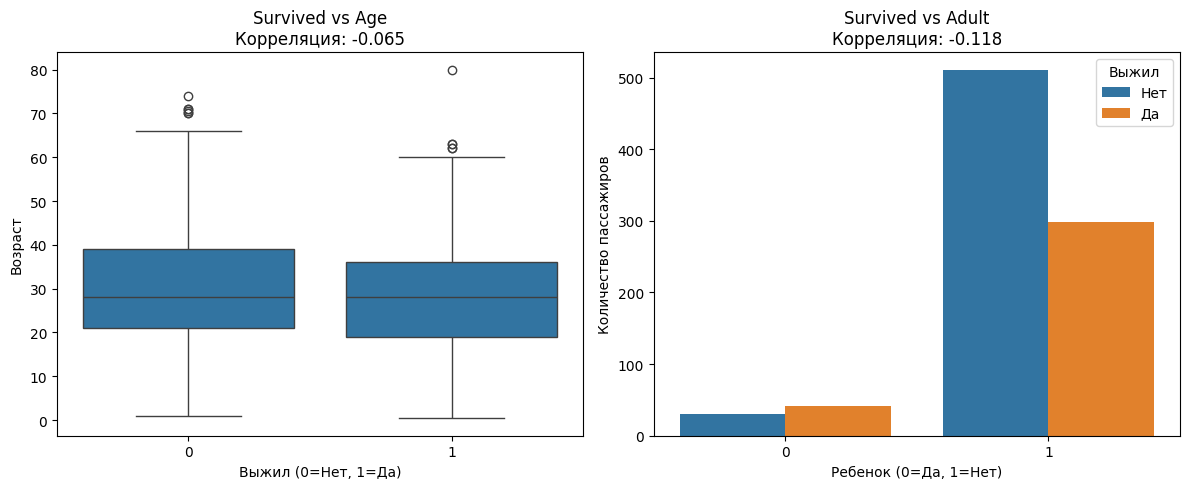

In [62]:
# Вычисление корреляций
corr_age = df['Survived'].corr(df['Age'].fillna(df['Age'].median()))
corr_adult = df['Survived'].corr(df['Adult'].fillna(1))  # Заменяем NaN для Miss на 1 (взрослый)

print(f"Корреляция Survived-Age: {corr_age:.3f}")
print(f"Корреляция Survived-Adult: {corr_adult:.3f}")

# Визуализация
plt.figure(figsize=(12, 5))

# График 1: Survived vs Age
plt.subplot(1, 2, 1)
sns.boxplot(x='Survived', y='Age', data=df)
plt.title(f'Survived vs Age\nКорреляция: {corr_age:.3f}')
plt.xlabel('Выжил (0=Нет, 1=Да)')
plt.ylabel('Возраст')

# График 2: Survived vs Adult
plt.subplot(1, 2, 2)
sns.countplot(x='Adult', hue='Survived', data=df)
plt.title(f'Survived vs Adult\nКорреляция: {corr_adult:.3f}')
plt.xlabel('Ребенок (0=Да, 1=Нет)')
plt.ylabel('Количество пассажиров')
plt.legend(title='Выжил', labels=['Нет', 'Да'])

plt.tight_layout()
plt.show()

Корреляция от нового признака Adult -0,118 чуть сильнее, чем на неочищенных данных Age - 0,065. В обоих случаях корреляция обратно-пропорциональная (чем меньше лет, тем больше шансов, боксплот с выжившими чуть ниже по возрастной шкале)

**Теперь проверим что будет если пропуски по Age игнорировать**

In [63]:
# Создаем df_corr, удаляя записи с Age == NaN
df_corr = df.dropna(subset=['Age']).copy()
# Вычисляем корреляции
corr_matrix = df_corr[['Survived', 'Age']].corr()

#Сравнение

print(f"\nРазмер df_corr после удаления NaN в Age: {len(df_corr)} записей, потеряно {len(df) - len(df_corr)} или {(len(df) - len(df_corr)) / len(df) * 100:.1f}% записей. существенно ")
print(f"Корреляция Survived-Age без Nan: {corr_matrix.loc['Survived', 'Age']:.3f}")
print(f"Корреляция Survived-Age неочищенная: {corr_age:.3f}")
print(f"Корреляция Survived-Adult с признаком Взрослый / ребенок: {corr_adult:.3f}")


Размер df_corr после удаления NaN в Age: 714 записей, потеряно 177 или 19.9% записей. существенно 
Корреляция Survived-Age без Nan: -0.077
Корреляция Survived-Age неочищенная: -0.065
Корреляция Survived-Adult с признаком Взрослый / ребенок: -0.118


как видим, при удалении пропусков по Age корреляция не сильно лучше неочищенного датасета

Следующим шагом:
- уберем все ненужные категориальные признаки name, ticket, Cabin, Embarked
- вместо Age, испоьзуем Adult
- пропуски с обращением Miss заполним категорией взрослых (1)
- преобразуем пол из категориального в целочисленный бинарный (male - 1, female - 0) с помощью LabelEncoder

In [64]:
# Удаление ненужных столбцов
columns_to_drop = ['Name', 'Ticket', 'Cabin', 'Embarked', 'Age']
df_clean = df.drop(columns=columns_to_drop)
# Преобразование признака 'Sex' в числовой бинарный (0, 1)
label_encoder = LabelEncoder()
df_clean['Sex'] = label_encoder.fit_transform(df_clean['Sex'])

In [65]:
df_clean['Adult'] = df_clean['Adult'].fillna(1)

In [66]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int64  
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Fare         891 non-null    float64
 7   Adult        891 non-null    Int64  
dtypes: Int64(1), float64(1), int64(6)
memory usage: 56.7 KB


**Датаcет готов для обучения** Выбросы были в в признаке "возраст", и являются объективными показателями количества людей старшего возраста, выбросы типа "возраст = 0" отсутствуют.

In [67]:
#обучаем модель
X = df_clean[['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Adult']]
y = df_clean['Survived']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25)

log_reg = LogisticRegression().fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")


Accuracy: 0.8161
Recall: 0.7111
Precision: 0.8101


In [68]:
y_scores = log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, thresh = roc_curve(y_test, y_scores)

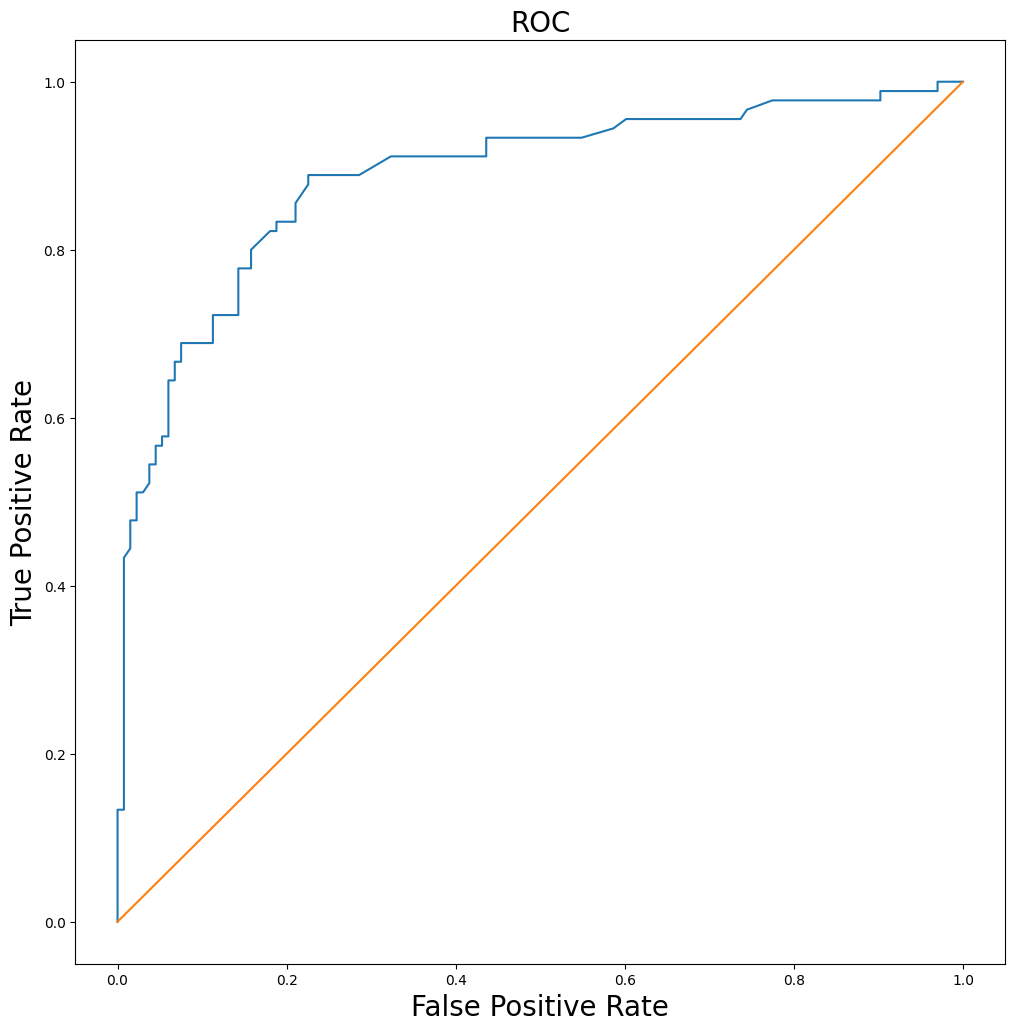

In [69]:
plt.figure(figsize=(12, 12))
plt.plot(fpr, tpr, label = 'Logreg')
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10),label = 'RedLine')
plt.title('ROC', fontdict={'fontsize': 20})
plt.xlabel('False Positive Rate', fontdict={'fontsize': 20})
plt.ylabel('True Positive Rate', fontdict={'fontsize': 20})
plt.show()

In [70]:
auc(fpr, tpr)

np.float64(0.8864661654135337)

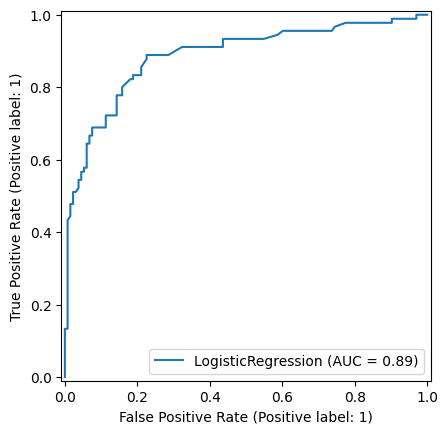

In [71]:
# проверим библиотечной функцией
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(log_reg, X_test, y_test)
plt.show()

2. Удалите все пропущенные значения и категориальные переменные. Обучите модель. Выберете и посчитайте метрику качества.

In [72]:
# Загрузка данных
data = pd.read_csv('train.csv')
# Удаление пропущенных значений
data = data.dropna()
# Удаление категориальных переменных
data = data.drop(['PassengerId', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1)
# Разделение на признаки и целевую переменную
X = data.drop('Survived', axis=1)
y = data['Survived']
# Масштабирование числовых признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
#Обучение модели
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [73]:
# Предсказания на тестовых данных
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Вероятности для AUC
# Расчет метрик
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"AUC: {auc:.4f}")

Accuracy: 0.7027
Recall: 1.0000
Precision: 0.6765
AUC: 0.7484


# 11. Выводы
**a) какие преобразования были сделаны и почему.**
- Преобразование пропусков age (принцип выше), потому что это значимый влияющий фактор.
- Преобразование категориальных male/female в целочисленные 0/1 для корректного обучения
- исключение невлияющих категориальных переменных
- проверка корреляции при потере данных (исключении пропусков из дата сета)

**b) метрики моделей из п. 2 и п. 10.**
Accuracy: 0.8161
Recall: 0.7111
Precision: 0.8101

На очищенных (преобразованных) данных:
- Accuracy: 0.8161 - модель правильно предсказывает выживание в 81,61% случаев
- Recall: 0.7111 - из всех реально выживших пассажиров модель правильно идентифицировала 71.1%.
- Precision: 0.8101 - из всех предсказанных моделью выживших действительно выжили 81,01%.
- AUC 89% модель показывает хорошую способность различать выживших и погибших (значение близко к 1)

На данных с удалением пропусков (п. 2):
- Accuracy: 0.7027 - результат хуже на 12 пунктов
- Recall: 1.0000 - из всех реально выживших, модель правильно идентифицировала всех
- Precision: 0.6765 - результат значительно хуже, из всех реально выживших выжило 67,7%
- AUC: 0.7484 модель на 15 пунктов хуже показывает способность различать выживших и погибших

**c) мнение о целесообразности работы с данными при построении моделей машинного обучения.**
Убеждён, что данные нужно обрабатывать с погружением в логику контекста, а не просто математической обработкой или дропом пропусков

**Нужно ли аналогичным образом исследовать и дополнять действительно большие данные?**

Нужно, потому что от масштаба датасета это не зависит. В PySpark возможно преобразовать любые большие данные до ограниченного количества категорий и затем обработать встроенными библиотеками.  